In [1]:
import pandas as pd
import warnings
import time
import matplotlib.pyplot as plt
from src.helper_methods import *
from src.pipe_store import *
warnings.filterwarnings('ignore')

# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# Load Dataset

In [2]:
path_cohort = '~/UMCUtrecht/KaplanMeier/DESAsurvival.pickle'
path_antibody = '~/UMCUtrecht/20211104_mismatch_ep_db.pickle'
df_abs = pd.read_pickle(path_antibody)
df_cohort = pd.read_pickle(path_cohort)
df = df_abs.merge(df_cohort, on='TransplantID')
print(df.columns)
cols = [
    'TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA', 'RecipientAge_NOTR', 
    'DonorAge_NOTR', 'TypeOfDonor_NOTR', 'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb',
    'CIPHour_DBD', 'CIPHour_DCD' , 'LivingDonorNum', # 'FailureCode10y'
]
df = df[cols]
df.columns

Index(['TransplantID', 'Epitope_Mismatch', 'DESA_Status', 'EpvsHLA_Donor',
       '#DESA', 'DESA', 'RecipientAge_NOTR', 'RecipientSex_NOTR',
       'DonorAge_NOTR', 'DonorSex_NOTR', 'Retransplant', 'TxYear', 'Center',
       'TypeOfDonor_NOTR', 'LivingDonorNum', 'GraftFunction_NOTR',
       'ColdIschaemicPeriod_NOTR', 'CIPHour', 'CIPHour_DBD', 'CIPHour_DCD',
       'CurrentPRA_NOTR', 'HighPRA_NOTR', 'IL2rMoAb', 'GraftSurvival10y',
       'GraftSurvival10Y_R', 'GraftSurvival1y', 'GraftSurvivalY1_R',
       'FailureCode10y', 'FailureCode10Y_R', 'FailureCode1Y_R',
       'FailureCode1y', 'RejectionCodeY10_R', 'PatientSurvival10Y',
       'PatientDeathCode10Y', 'GraftSurvival3m', 'FailureCode3m'],
      dtype='object')


Index(['TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA',
       'RecipientAge_NOTR', 'DonorAge_NOTR', 'TypeOfDonor_NOTR',
       'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb', 'CIPHour_DBD',
       'CIPHour_DCD', 'LivingDonorNum'],
      dtype='object')

# Finding relevant DESA using Automation

In [3]:
from src.pipe_store import df_inv_val_split
from src.helper_methods import  kaplan_meier_curves_automation, plot_kaplan_meier_curve_automation
from collections import  defaultdict
from time import time
# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def inv_val_split(df, val_size:float, donor_type='Deceased'):
    df_dead = df[df.TypeOfDonor_NOTR == donor_type]
    msk = np.random.rand(len(df_dead)) < val_size
    return (df_dead[~msk], df_dead[msk])

def cross_val_split(df, k_fold:int, donor_type='Deceased'):
    df_type = df[df.TypeOfDonor_NOTR == donor_type]
    df_type = df_type.sample(frac=1).reset_index(drop=True) # shuffle dataframe
    fold_samples = len(df_type) // k_fold + 1
    return [df_type.loc[(i-1) * fold_samples: i * fold_samples] for i in range(1, 6)]

def summerize_results(df_res, iter, add_val_res):
    freq_inv = [f'freq_iter_{i}'  for i in range(1, iter + 1)]
    avg_diff_early = [f'avg_diff_early_inv_iter_{i}' for i in range(1, iter + 1)]
    avg_diff_mid = [f'avg_diff_mid_inv_iter_{i}' for i in range(1, iter + 1)]
    avg_diff_late = [f'avg_diff_late_inv_iter_{i}' for i in range(1, iter + 1)]
    p_value_inv = [f'p_value_inv_iter_{i}' for i in range(1, iter + 1)]

    df_sum = pd.DataFrame()
    df_sum['epitope'] = df_res['epitope']
    df_sum['freq_inv'] = df_res[freq_inv].mean(axis=1)
    df_sum['#sig_p_value_inv'] = df_res[p_value_inv].apply(lambda x: len([p_val for p_val in x if p_val < 0.05]), axis=1)
    df_sum['avg_diff_early_inv'] = df_res[avg_diff_early].mean(axis=1)
    df_sum['avg_diff_mid_inv'] = df_res[avg_diff_mid].mean(axis=1)
    df_sum['avg_diff_late_inv'] = df_res[avg_diff_late].mean(axis=1)
    
    if add_val_res:
        freq_val = [f'freq_val_iter_{i}'  for i in range(1, iter + 1)]
        avg_diff_early_val = [f'avg_diff_early_val_iter_{i}' for i in range(1, iter + 1)]
        avg_diff_mid_val = [f'avg_diff_mid_val_iter_{i}' for i in range(1, iter + 1)]
        avg_diff_late_val = [f'avg_diff_late_val_iter_{i}' for i in range(1, iter + 1)]
        p_value_val = [f'p_value_val_iter_{i}' for i in range(1, iter + 1)]

        df_sum['freq_val'] = df_res[freq_val].mean(axis=1)
        df_sum['#sig_p_value_val'] = df_res[p_value_val].apply(lambda x: len([p_val for p_val in x if p_val < 0.05]), axis=1)
        df_sum['avg_diff_early_val'] = df_res[avg_diff_early_val].mean(axis=1)
        df_sum['avg_diff_mid_val'] = df_res[avg_diff_mid_val].mean(axis=1)
        df_sum['avg_diff_late_val'] = df_res[avg_diff_late_val].mean(axis=1)
    return df_sum

def epitope_relevance_validation(df, iter:int, ep_freq_inv:int, ep_freq_val:int, val_size:int, add_val_res:bool=False):
    collect_res = defaultdict(dict)

    confounders = [
        'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
        'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
        'CIPHour_DBD', 'CIPHour_DCD', 
    ]
    treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
    for i in range(1, iter + 1):
        now = time()
        df_inv, df_val = inv_val_split(df, val_size=val_size, donor_type='Deceased')
        list_set_desa = df_inv[df_inv.DESA_Status == 'DESA'].DESA.values
        epitopes = {ep for desa_set in list_set_desa for ep in desa_set}
        for ep in epitopes:
            freq_inv = df_inv.DESA.apply(lambda x: ep in x).sum()
            freq_val = df_val.DESA.apply(lambda x: ep in x).sum()
            if (freq_inv >= ep_freq_inv) & (freq_val >= ep_freq_val):
                try:
                    df_tret_group = create_treatment_grups(df_inv, [{ep}])
                    df_weight = find_ipw(df_tret_group, confounders, treatments, verbose=False)
                    labels = ['Other_DESA', 'Specific_DESA']
                    kmfs, p_value_inv = kaplan_meier_curves_automation(df_weight, desa_spec=ep, donor_type='Deceased', labels=labels, adjust=True)
                except Exception as e:
                    print(f'Investigation Exception: {e} Epitope: {ep}')
                    continue
                km_rest, km_ep = kmfs[0], kmfs[1]
                diff = km_ep.survival_function_.values - km_rest.survival_function_.values
                collect_res[ep][f'freq_iter_{i}'] = int(freq_inv)
                collect_res[ep][f'avg_diff_early_inv_iter_{i}'] = diff[0:250].mean()
                collect_res[ep][f'avg_diff_mid_inv_iter_{i}'] = diff[250:650].mean()
                collect_res[ep][f'avg_diff_late_inv_iter_{i}'] = diff[650:].mean()
                collect_res[ep][f'avg_diff_inv_iter_{i}'] = diff.mean()
                collect_res[ep][f'p_value_inv_iter_{i}'] = p_value_inv
                if add_val_res:
                    try:
                        df_tret_group_val = create_treatment_grups(df_val, [{ep}])
                        df_weight_val = find_ipw(df_tret_group_val, confounders, treatments, verbose=False)
                        labels = ['Other_DESA', 'Specific_DESA']
                        kmfs_val, p_value_val = kaplan_meier_curves_automation(df_weight_val, desa_spec=ep, donor_type='Deceased', labels=labels, adjust=True)
                    except Exception as e:
                        print(f'Validation Exception: {e} Epitope: {ep}')
                    km_rest, km_ep = kmfs_val[0], kmfs_val[1]
                    diff_val = km_ep.survival_function_.values - km_rest.survival_function_.values

                    collect_res[ep][f'freq_val_iter_{i}'] = int(freq_val)
                    collect_res[ep][f'avg_diff_early_val_iter_{i}'] = diff_val[0:250].mean()
                    collect_res[ep][f'avg_diff_mid_val_iter_{i}'] = diff_val[250:650].mean()
                    collect_res[ep][f'avg_diff_late_val_iter_{i}'] = diff_val[650:].mean()
                    collect_res[ep][f'p_value_val_iter_{i}'] = p_value_val
                    collect_res[ep][f'avg_diff_val_iter_{i}'] = diff_val.mean()
        
        print(f'Iteration {i} is concluded in {time() - now} seconds')
    df_res = pd.DataFrame(collect_res).T.reset_index().rename(columns={'index':'epitope'})
    return summerize_results(df_res, iter, add_val_res), df_res

def plot_km_curve(df:pd.DataFrame, donor_type:str, ep:set, adjust:bool=False, num_curves:int=3):
    confounders = [
        'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
        'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
        'CIPHour_DBD', 'CIPHour_DCD', 
    ]

    treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
    ep = set(ep)
    labels = ['No DESA', 'Other DESA', 'Specific_DES']
    df_tret_group = create_treatment_grups(df, [ep])
    df_weight = find_ipw(df_tret_group, confounders, treatments, verbose=False)
    if num_curves == 3:
        kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=ep, donor_type=donor_type, labels=labels, adjust=adjust)
    if num_curves == 2:
        kmfs, p_value = kaplan_meier_curves_automation(df_weight, desa_spec=ep, donor_type=donor_type, labels=labels, adjust=adjust)
    plot_kaplan_meier_curve(kmfs, p_value, verbose=True, title='')



In [21]:
df_filtered = df[(df.TypeOfDonor_NOTR == 'Deceased')]

res = [
    epitope_relevance_validation(df_filtered, iter=1, ep_freq_inv=2, ep_freq_val=2, val_size=0.3, add_val_res=True)
    for _ in range(100)
]

Iteration 1 is concluded in 28.80117392539978 seconds
Iteration 1 is concluded in 33.24733304977417 seconds
Iteration 1 is concluded in 26.03756809234619 seconds
Iteration 1 is concluded in 30.60661506652832 seconds
Iteration 1 is concluded in 27.270170211791992 seconds
Iteration 1 is concluded in 28.262916088104248 seconds
Iteration 1 is concluded in 29.720799207687378 seconds
Iteration 1 is concluded in 26.833304166793823 seconds
Iteration 1 is concluded in 29.132630109786987 seconds
Iteration 1 is concluded in 26.12139916419983 seconds
Iteration 1 is concluded in 24.604939937591553 seconds
Iteration 1 is concluded in 32.91599798202515 seconds
Iteration 1 is concluded in 23.762420415878296 seconds
Iteration 1 is concluded in 30.908555030822754 seconds
Iteration 1 is concluded in 28.01178503036499 seconds
Iteration 1 is concluded in 25.566953897476196 seconds
Iteration 1 is concluded in 31.537792921066284 seconds
Iteration 1 is concluded in 26.951301097869873 seconds
Iteration 1 is co

In [22]:
import pickle 

# save
filehandler = open('results_final.pickle', 'wb') 
pickle.dump(res, filehandler)
# load
# fileObj = open('results.pickle', 'rb')
# res = pickle.load(fileObj)

# df_res, df_sum = [tup[1] for tup in res], [tup[0] for tup in res]

In [11]:
def analyse_results(df, threshold:float, val:bool, output:str, relevance:str):
    if val: # Both investigation & validation  
        if relevance == 'good':
            df_ep = df[(df.avg_diff_inv_iter_1 > threshold) & (df.avg_diff_val_iter_1 > threshold)]
        else: 
            df_ep = df[(df.avg_diff_inv_iter_1 < threshold) & (df.avg_diff_val_iter_1 < threshold)]
    else: # Only Investigation
        if relevance == 'good':
            df_ep = df[df.avg_diff_inv_iter_1 > threshold]
        else:
            df_ep = df[df.avg_diff_inv_iter_1 < threshold]

    
    return {'df': df_ep, 'epitope': set(df_ep.epitope.tolist())}.get(output)



In [16]:
def analyse_results_ext(dfs, threshold:float, val:bool, relevance:str):
    from collections import defaultdict, Counter
    from statistics import mean
    agg_dict = defaultdict(lambda: defaultdict(list))

    for df in dfs:
        if val: # Both investigation & validation  
            if relevance == 'good': # threshold should be positive
                df_ep = df[(df.avg_diff_inv_iter_1 > threshold) & (df.avg_diff_val_iter_1 > threshold)]
            else: # threshold should be negative
                df_ep = df[(df.avg_diff_inv_iter_1 < threshold) & (df.avg_diff_val_iter_1 < threshold)]
        else: # Only Investigation
            if relevance == 'good':  # threshold should be positive
                df_ep = df[df.avg_diff_inv_iter_1 > threshold]
            else: # threshold should be negative
                df_ep = df[df.avg_diff_inv_iter_1 < threshold]
        for ep in df_ep.epitope.unique():
            df_filt = df[df.epitope == ep]
            agg_dict[ep]['count'].append(1)
            agg_dict[ep]['freq_inv'].append(df_filt['freq_iter_1'].values[0])
            agg_dict[ep]['freq_val'].append(df_filt['freq_val_iter_1'].values[0])
            agg_dict[ep]['avg_diff_inv_iter_1'].append(df_filt['avg_diff_inv_iter_1'].values[0])
            agg_dict[ep]['avg_diff_val_iter_1'].append(df_filt['avg_diff_val_iter_1'].values[0])
            
            agg_dict[ep]['p_value_inv'].append(round(df_filt['p_value_inv_iter_1'].values[0], 3))
            agg_dict[ep]['p_value_val'].append(round(df_filt['p_value_val_iter_1'].values[0], 3))

    df_final = pd.DataFrame(agg_dict).T.reset_index().rename(columns={'index':'epitope'})
    df_final['count'] = df_final['count'].apply(sum)
    df_final['freq_inv'] = df_final['freq_inv'].apply(mean)
    df_final['freq_val'] = df_final['freq_val'].apply(mean)
    df_final['avg_diff_inv_iter_1'] = df_final['avg_diff_inv_iter_1'].apply(mean)
    df_final['avg_diff_val_iter_1'] = df_final['avg_diff_val_iter_1'].apply(mean)
    # df_final['p_value_inv'] = df_final['p_value_inv'].apply(lambda x: Counter(['sign' if pval < 0.2 else 'insig' for pval in x]))
    # df_final['p_value_val'] = df_final['p_value_val'].apply(lambda x: Counter(['sign' if pval < 0.2 else 'insig' for pval in x]))

    return df_final.sort_values(by='count', ascending=False)


In [18]:
ep_count_bad_ext = analyse_results_ext(df_res, -0.1, val=True, relevance='bad')
# ind_inv = ep_count_bad_ext.p_value_inv.apply(lambda x: x['sign'] > x['insig'])
# ind_val = ep_count_bad_ext.p_value_val.apply(lambda x: x['sign'] > x['insig'])
# ep_count_bad_ext[ind_inv & ind_val]

In [19]:
ep_count_bad_ext

,epitope,count,freq_inv,freq_val,avg_diff_inv_iter_1,avg_diff_val_iter_1,p_value_inv,p_value_val
3,71TD,59,4.305085,2.694915,-0.572419,-0.546963,"[0.0, 0.004, 0.001, 0.002, 0.0, 0.001, 0.078, ...","[0.0, 0.004, 0.001, 0.002, 0.0, 0.001, 0.078, ..."
45,45EV,42,12.476190,5.523810,-0.168865,-0.318941,"[0.094, 0.078, 0.19, 0.206, 0.195, 0.076, 0.10...","[0.094, 0.078, 0.19, 0.206, 0.195, 0.076, 0.10..."
25,70DA,37,4.351351,2.648649,-0.336815,-0.332608,"[0.024, 0.437, 0.119, 0.273, 0.078, 0.438, 0.0...","[0.024, 0.437, 0.119, 0.273, 0.078, 0.438, 0.0..."
9,80TLR,36,6.111111,2.888889,-0.276413,-0.443052,"[0.783, 0.652, 0.436, 0.192, 0.123, 0.131, 0.0...","[0.783, 0.652, 0.436, 0.192, 0.123, 0.131, 0.0..."
10,76ED,36,9.277778,3.722222,-0.172570,-0.388493,"[0.169, 0.27, 0.429, 0.042, 0.262, 0.212, 0.09...","[0.169, 0.27, 0.429, 0.042, 0.262, 0.212, 0.09..."
...,...,...,...,...,...,...,...,...
56,66KA,1,11.000000,4.000000,-0.104512,-0.424056,[0.452],[0.452]
55,107W,1,8.000000,5.000000,-0.147086,-0.324297,[0.691],[0.691]
30,133RS,1,11.000000,4.000000,-0.114981,-0.427448,[0.996],[0.996]
47,245AS,1,3.000000,2.000000,-0.189289,-0.163979,[0.079],[0.079]


In [14]:
ep_count_good_ext = analyse_results_ext(df_res, +0.1, val=True, relevance='good')
ep_count_good_ext.head(30)

,epitope,count,freq_inv,freq_val,avg_diff_inv_iter_1,avg_diff_val_iter_1,p_value_inv,p_value_val
2,173K,82,5.743902,3.256098,0.268432,0.272993,"{'sign': 33, 'insig': 49}","{'sign': 33, 'insig': 49}"
6,163RW,82,8.365854,3.634146,0.194889,0.241714,"{'insig': 63, 'sign': 19}","{'insig': 63, 'sign': 19}"
13,37FL,79,9.860759,4.139241,0.196687,0.230125,"{'insig': 69, 'sign': 10}","{'insig': 69, 'sign': 10}"
18,80I,62,4.387097,2.612903,0.277065,0.272358,"{'sign': 29, 'insig': 33}","{'sign': 29, 'insig': 33}"
8,152RA,61,5.180328,2.819672,0.241097,0.249637,"{'insig': 45, 'sign': 16}","{'insig': 45, 'sign': 16}"
31,71ATD,55,8.509091,3.490909,0.172807,0.227872,"{'insig': 51, 'sign': 4}","{'insig': 51, 'sign': 4}"
10,193PL,53,4.415094,2.584906,0.248669,0.250069,"{'insig': 37, 'sign': 16}","{'insig': 37, 'sign': 16}"
29,73TVS,52,4.442308,2.557692,0.217731,0.255506,"{'insig': 44, 'sign': 8}","{'insig': 44, 'sign': 8}"
19,37F,45,3.644444,2.355556,0.248999,0.261063,"{'sign': 5, 'insig': 40}","{'sign': 5, 'insig': 40}"
4,267QE,45,3.622222,2.377778,0.249646,0.249128,"{'insig': 32, 'sign': 13}","{'insig': 32, 'sign': 13}"


In [345]:
print(ep_count_good_df[ep_count_good_df['count'].ge(50)].epitope.tolist())

['71ATD', '193PL', '267QE', '80I', '163RW', '152RA', '173K', '37FL', '152A', '37F']


In [346]:
print(ep_count_bad_df[ep_count_bad_df['count'].ge(30)].epitope.tolist())

['70DRA', '67F', '71TD', '45KE', '80TLR', '70DA', '62QE', '76ET', '76ED', '45GV', '158T', '144QL']


In [150]:
df_res_f[df_res_f.epitope == '70GT']

,epitope,freq_iter_1,avg_diff_inv_iter_1,p_value_inv_iter_1,freq_val_iter_1,p_value_val_iter_1,avg_diff_val_iter_1
111,70GT,8.0,-0.071702,0.816218,4.0,0.816218,-0.66126


In [112]:
relevant_desa_inv = df_res[(df_res.avg_diff_early_inv_iter_1 < - 0.10) & (df_res.avg_diff_late_inv_iter_1 < - 0.20)].epitope.values
relevant_desa_inv

array(['70DA', '108T', '67F', '74EL', '71TD', '30D', '45GV', '62QE',
       '9F[DQ]', '80TLR', '70DRA', '71A', '67VT', '28H', '142M', '74A',
       '45EV', '70GT', '76ESN', '96EV', '161D', '144QL'], dtype=object)

In [81]:
relevant_desa_val = df_res[(df_res.avg_diff_early_val_iter_1 < - 0.0) | (df_res.avg_diff_late_val_iter_1 < - 0.0)].epitope.values
relevant_desa_val

array(['98E', '46VY', '31I', '65GK', '80TA', '185I', '62QE', '74L',
       '55PPD', '96Q', '127K', '71TD', '9T', '150AAH', '96Y', '70QT',
       '149H', '77N[DR]', '37YV[DR]', '71A', '108T', '30D', '70DRA',
       '76ESI', '13SE', '30H[DQ]', '9F[DQ]', '74A', '96HK', '77T[DQ]',
       '163RG', '62GE', '45EV', '82LR', '76VDT', '156QA', '245AS', '120N',
       '74S', '182N', '96EV', '44RMA', '145KHA', '86A', '199V', '245V',
       '31FH', '125SQ', '81ALR', '56L', '37YV[DQ]', '37S', '62GRN',
       '37YA', '97M', '107W', '76EN', '28H', '70DA', '144TKH', '87Y',
       '44KM', '116I', '70QA', '76ET', '98Q', '80TLR', '45GV', '57V[DQ]',
       '52LL', '151AHV', '67VG', '144KR', '55R', '56R', '142M', '66NM',
       '52PQ', '95V', '73AN', '97I', '193AV'], dtype=object)

In [82]:
set(relevant_desa_val) & set(relevant_desa_inv)

{'150AAH', '45EV', '45GV', '55PPD', '70DRA', '71TD', '76ET', '76VDT', '80TLR'}

In [124]:
relevant_desa = df_sum[(df_sum.repe_relevant >=2) & (df_sum.p_value <= 0.05)].epitope.tolist()
df_sum[(df_sum.repe_relevant >=2) & (df_sum.p_value <= 0.05)]
# df_sum[df_sum.p_value <= 0.05]
# # print(df_sum[df_sum.p_value <= 0.05].epitope.tolist())

,epitope,freq,p_value,sum_diff,repe,repe_relevant
139,71TD,5.40,0.006153,-553.369600,5,5
152,144QL,3.75,0.039876,-512.022145,4,3
203,114H,3.00,0.000032,-421.641358,2,2
215,77D,3.00,0.038458,-164.652426,2,2
220,74A,4.00,0.015570,-275.348628,2,2
221,114Q,3.00,0.000018,-715.886175,2,2


In [28]:
# df_res['144QL']

In [40]:
from src.helper_methods import _get_indexes
collect_res = defaultdict(list)

confounders = [
    'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
    'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
    'CIPHour_DBD', 'CIPHour_DCD', 
]
treatments = ['Other_DESA', 'Specific_DESA']

df_inv, df_val = df_inv_val_split(df, val_size=0.3)

list_set_desa = df_inv[df_inv.DESA_Status == 'DESA'].DESA.values
epitopes = {ep for desa_set in list_set_desa for ep in desa_set}
for ep in ['45EV', '69AA']:
    freq = df_inv.DESA.apply(lambda x: ep in x).sum()
    if freq >= 1:
        # try:
        inds = _get_indexes(df_inv, donor_type='Deceased', desa_spec=ep)
        print([ind.sum() for ind in inds])
        # print(ind_desa.sum(), ind_other.sum())
        # df_tret_group = create_treatment_grups(df_inv, [{ep}])
        # df_weight = find_ipw(df_tret_group, confounders, treatments, verbose=False)
        # labels = ['No DESA', 'Other DESA', 'specific_DESA']
        # kmfs, p_value = kaplan_meier_curves_automation(df_weight, desa_spec=ep, donor_type='Deceased', labels=labels, adjust=True)
        # # except Exception as e:
        # #     print(f'Exception: {e} Epitope: {ep}')
        # km_rest, km_ep = kmfs[0], kmfs[1]
        # diff = km_ep.survival_function_.values - km_rest.survival_function_.values
        # collect_res['epitope'].append(ep)
        # collect_res['freq'].append(freq)
        # collect_res['sum_diff'].append(diff.sum())
        # collect_res['p_value'].append(p_value)
        


[2051, 221, 13]
[2051, 233, 1]


In [101]:
df_dead = df[df.TypeOfDonor_NOTR == 'Deceased']
df_inv, df_val = df_inv_val_split(df_dead, val_size=0.3)
df_res = find_relevant_epitope(df_inv, ep_freq=3)

In [103]:

relevant_desa = df_res[(df_res.p_value <= 0.05)].epitope.values
df_res[(df_res.p_value <= 0.05)]

,epitope,freq,sum_diff,p_value
5,45GV,8.0,-436.934745,0.011925
35,94I,4.0,-478.582569,0.023142
38,46VY,4.0,-371.727093,0.012265
43,193AV,4.0,-217.013691,0.032671
45,74A,5.0,-355.034930,0.001921
77,65QIA,3.0,-66.768730,0.049508
145,71TD,4.0,-551.434399,0.003410
156,97V,3.0,-577.239578,0.003124
158,144QL,4.0,-646.872356,0.000137
175,70DA,7.0,-448.491047,0.013601


Top curve: 75.64, Middle curve:  65.48, Lower curve: 26.79
10-Year Gap is:  38.69
1-Year Gap is:  20.38


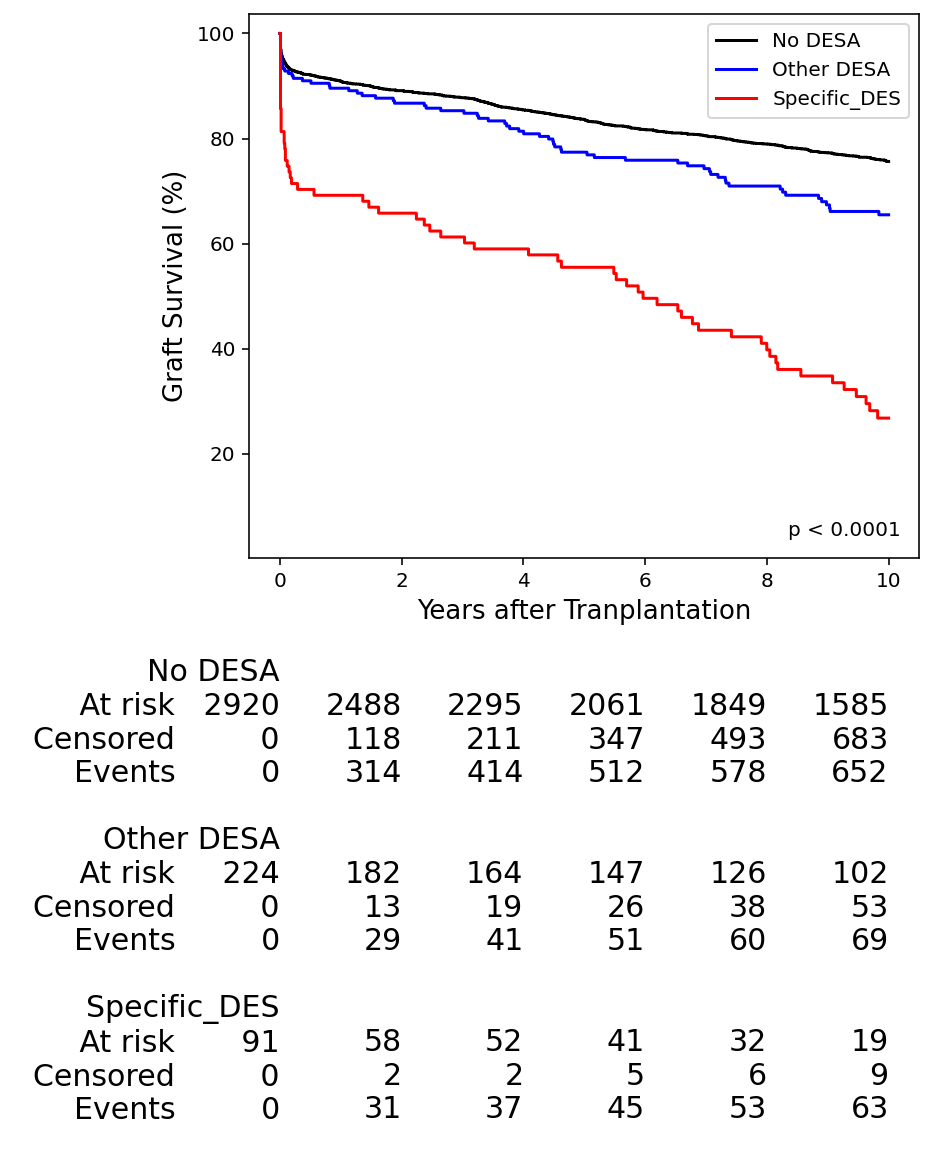

In [43]:
# relevant_desa = ['74A', '94I', '71TD', '150AH', '193AV', '150AAH', '76ED', '144QL', '114H', '66IY', '114Q', '105S', ]
# relevant_desa = {'150AAH', '45EV', '45GV', '55PPD', '70DRA', '71TD', '76ET', '76VDT', '80TLR'}
# relevant_desa = ['70DA', '44RME', '46VY', '6C', '31FH', '131S', '56PD', '67F',
#        '94I', '30G[DR]', '71TD', '114H', '66NH', '45GV', '67LQ', '80TLR',
#        '74Y', '70DRA', '71A', '70DR', '150AAH', '66NV', '105S', '114Q',
#        '74A', '45EV', '44RMA', '70Q', '96EV', '55RPD', '70IAQ', '144QL']
df_dead = df[df.TypeOfDonor_NOTR == 'Deceased']
# relevant_desa = ['44KM', '70DRA', '80TLR', '76ET', '150AAH', '144QL', '71TD', '45GV', '163RG', '80TA', '70DA', '67F']
# relevant_desa = ['70DRA', '80TLR', '71TD', '76ET', '163RG', '76ED', '80TA', '45GV', '67VG', '70DA', '144QL', '158T', '71A', '45EV']
# relevant_desa = ['66IF', '69AA', '16Y', '9T', '152RA']
relevant_desa =  ['71TD', '76ED', '144QL', '70DA', '45KE', '62QE', '45EV', '150AAH',
       '71A', '74Y', '193AV', '105S', '149H', '108T', '31FH', '96HK',
       '74A', '245AS', '6C']
plot_km_curve(df_dead, donor_type='Deceased', ep=relevant_desa, adjust=False)



In [90]:

class_I = { '44RMA', '45KE', '56R', '62EE', '62GRN', '62QE', '65QIA', '66NH', '71TD', '73ID', '74Y', '76ED', '76VDT', '80TLR', '94I', '97V', 
           '105S', '144QL', '150AAH', '150AH', '158T', '193AV', '207S', '245AS' }
class_II_dr = {'4Q', '6C', '30D', '30G[DR]', '31FY', '31FH', '32H', '37S', '67F', '70DA', '70DRA', '71A', '74A', '74L', '96EV', '96HK', '108T', '140TV', '142M', '149H'}
class_II_dq = {'45GV','45EV', '46VY'}

good_epitopes = {
    '30C', '37F', '37YV[DQ]', '55PPA', '62LQ', '71ATD', '71QS', '73AN', '73TVS', '80I', '97S', 
    '130Q', '147L', '152A', '152RA', '152RR', '163RW', '173K', '177DT', '180E', '193PL', '267QE',
    '44RT', '245V',
}


old_rel_desa = class_I | class_II_dr | class_II_dq
# confounders = [
#     'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
#     'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
#     'CIPHour_DBD', 'CIPHour_DCD', 
# ]

# treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
# # treatments = [ 'Other_DESA', 'Specific_DESA']
# # ep = {'77T[DQ]'}
# ep = set(relevant_desa)
# labels = ['No DESA', 'Other DESA', 'Specific_DESA']

# df_tret_group = create_treatment_grups(df, [ep])
# df_weight = find_ipw(df_tret_group, confounders, treatments, verbose=False)

# kmfs, p_value = kaplan_meier_curves_automation(df_weight, desa_spec=ep, donor_type='Deceased', labels=labels, adjust=True)
# plot_kaplan_meier_curve_automation(kmfs, p_value, verbose=True, title='Deceased Donor (N=3235)')

In [91]:
old_rel_desa & set(relevant_desa)

{'149H',
 '150AAH',
 '245AS',
 '45EV',
 '46VY',
 '62QE',
 '66NH',
 '70DA',
 '70DRA',
 '71A',
 '74A',
 '94I',
 '96HK'}

# Validation

Top curve: 51.51, Lower curve: 46.67
10-Year Gap is:  4.85
1-Year Gap is:  8.27


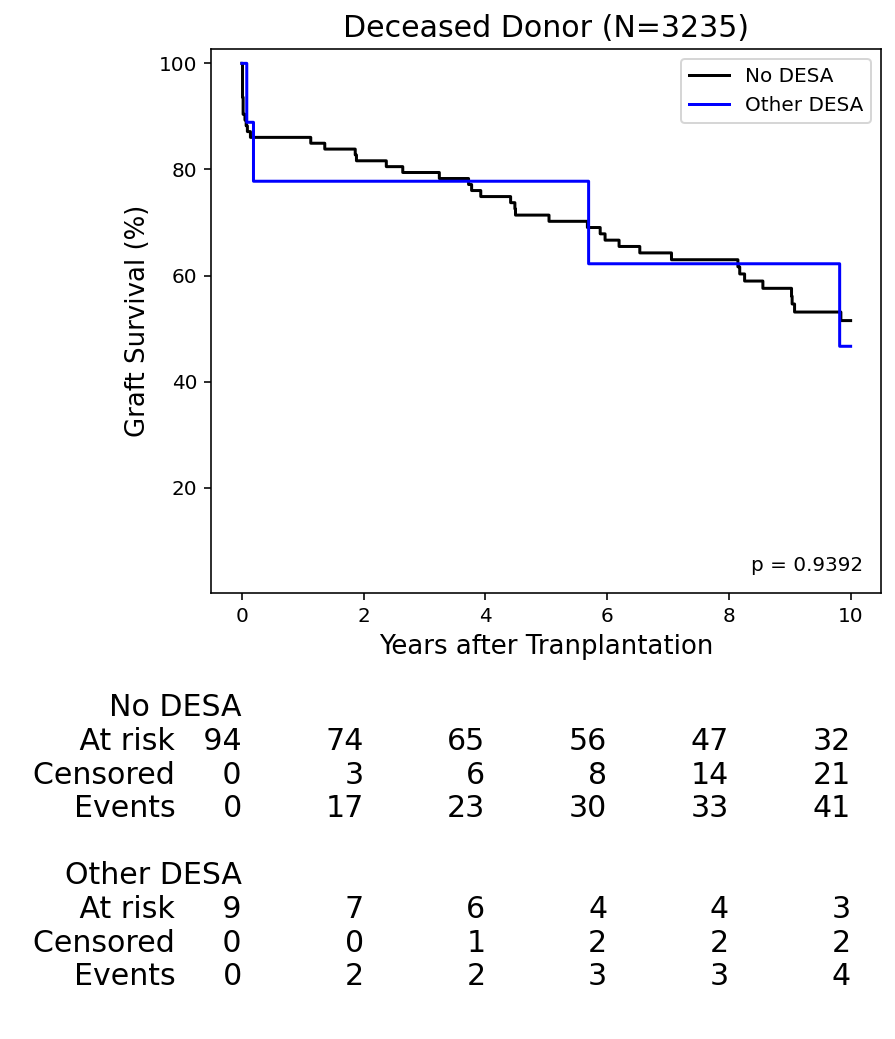

In [108]:

plot_km_curve(df_val, donor_type='Deceased', ep=relevant_desa, adjust=False)

In [123]:
df_living = df[df.TypeOfDonor_NOTR == 'Living']
plot_km_curve(df_living, donor_type='Living', ep=relevant_desa, adjust=False)

ValueError: zero-size array to reduction operation maximum which has no identity